In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
import statsmodels.api as sm

from datetime import datetime

In [20]:
data = pd.read_csv("data/ghana_gdp.csv",parse_dates=['year'], index_col=['year']) # считываем датасет
data.head() 

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot:xlabel='year'>

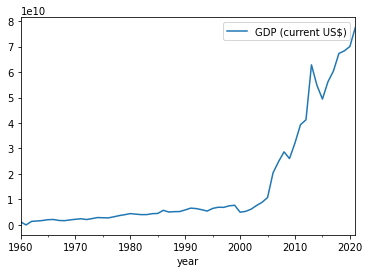

In [21]:
data.plot() # визуализируем исходный временной ряд

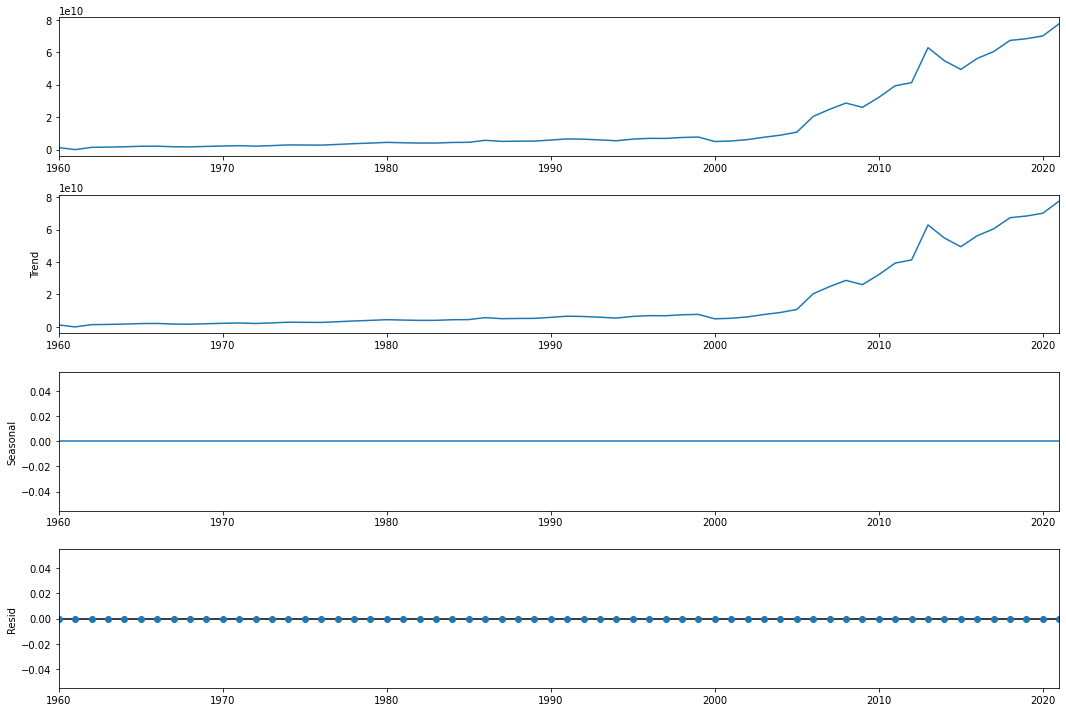

In [24]:
plt.rcParams["figure.figsize"] = 15, 10

result = seasonal_decompose(data)
result.plot()
plt.show()

Вывод: В наличии тренд (рост), сезонность и шум отсутствуют, так как выборка небольшая (одно значение в год).

In [25]:
# Отложим последние три года из датасета как тестовую выборку для оценки результатов предсказания.
test_df = data.iloc[-4:-1]
train_df = data.iloc[:-4]

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно. 

Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

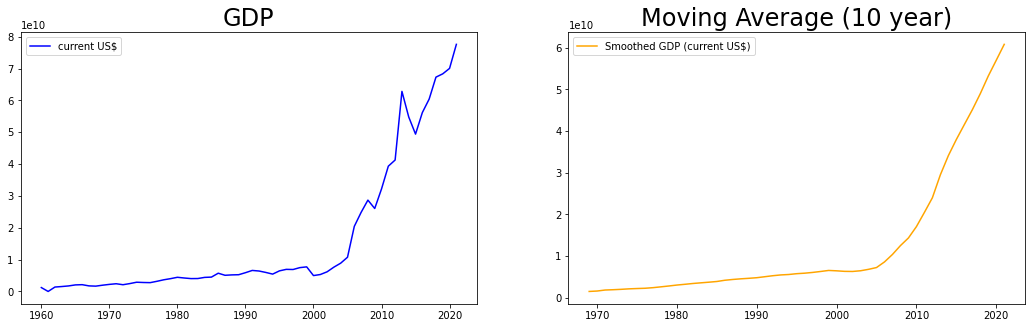

In [39]:
plt.rcParams["figure.figsize"] = 18, 5

fig, ax = plt.subplots(1, 2)

# Окно в декаду (Window = 10)
ax[0].plot(data, color="blue", label="current US$")
ax[0].set_title("GDP", size=24)
ax[0].legend()

ax[1].plot(
    data.rolling(window=10).mean(),
    color="orange",
    label="Smoothed GDP (current US$)",
)

ax[1].set_title("Moving Average (10 year)", size=24)
ax[1].legend()

plt.show()

Сглаживание позволяет более наглядно оценить общий тренд

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. 

In [40]:
from statsmodels.tsa.stattools import adfuller

adfuller(data)

(2.373839356148917,
 0.9989974617734,
 0,
 61,
 {'1%': -3.542412746661615,
  '5%': -2.910236235808284,
  '10%': -2.5927445767266866},
 2357.104266762714)

In [41]:
adfuller(data.diff().dropna())

(-1.5879441118004771,
 0.48964671777435337,
 11,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2308.523748792752)

In [44]:
data_diff_1 = data.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()
data_diff_3 = data_diff_2.diff().dropna()
test1 = adfuller(data_diff_3)

print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -5.278476343687489
p-value:  6.066691711554474e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


In [45]:
d=3

Вывод: исходный временной ряд является интегрированным рядом 3-го порядка

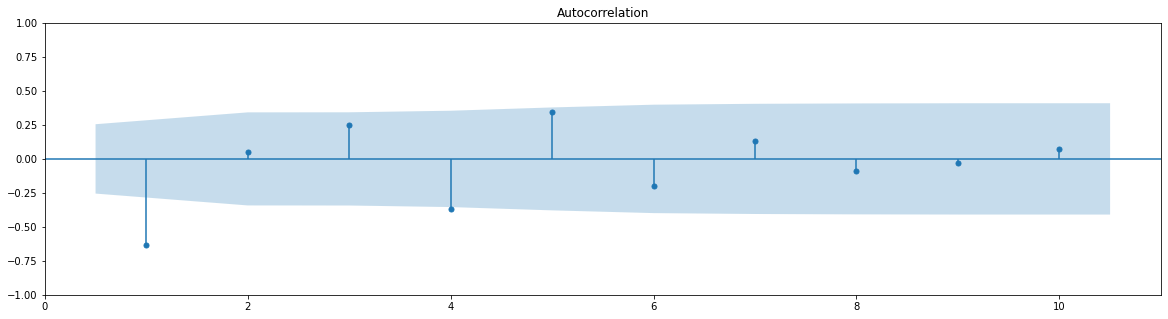

In [50]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(data_diff_3, lags=10, zero=False)
plt.show()

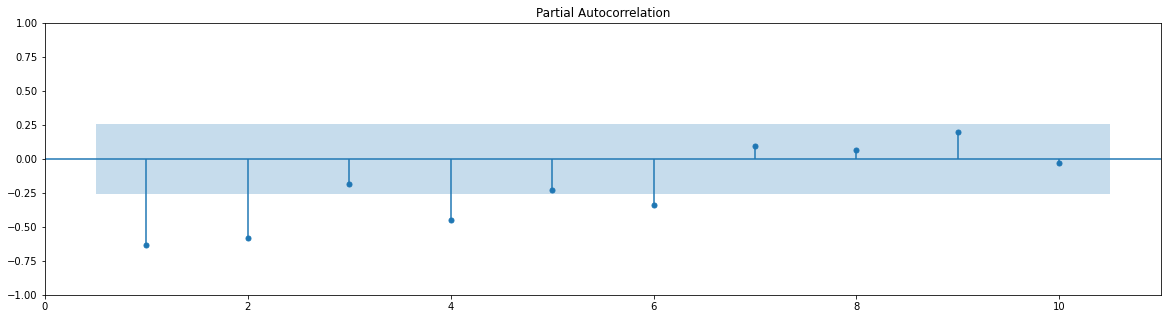

In [51]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(data_diff_3, lags=10, method="ywm", zero=False)
plt.show()

Ряд нестационарен